In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torchvision
import timm
import gc

from keras.utils import  to_categorical

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Функции

In [4]:
def get_num_correct(preds, labels):
        return preds.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [5]:
def load_data(df_name_id, size=256, d_type = torch.float32, aug = False, aug_k = 2, device='cpu', percent_test = 0.15):
    n_sample = df_name_id.shape[0]
    n_sample_y = df_name_id['label_id'].unique().shape[0]
    Y = to_categorical(df_name_id['label_id'].to_numpy(), num_classes=n_sample_y)

    X = torch.zeros((n_sample, 3, size, size), dtype=torch.uint8)
    Y = torch.from_numpy(Y)

    for index in tqdm(range(n_sample)):
        name = df_name_id.iloc[index, 0]
        path = f'train/train/{name}'
        image = Image.open(path).resize((size, size)).convert('RGB')
        image = pil_to_tensor(image)
        X[index] = image

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=percent_test)

    if aug == True:
        trans = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=1),
        torchvision.transforms.RandomVerticalFlip(p=1),
        torchvision.transforms.RandomRotation(90),
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.5)),
        torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        ])

        n_sample = x_train.shape[0]
        x_train = x_train.repeat(aug_k, 1, 1, 1)
        y_train = y_train.repeat(aug_k, 1)

        loader = DataLoader(TensorDataset(x_train[n_sample:]), batch_size=20, shuffle=False)
        for k in range(1, aug_k):
            counter = n_sample
            for x in tqdm(loader):
                x = x[0].to(device)
                x = trans(x)
                x = x.to('cpu')
                x_train[counter * k : counter * k + len(x)] = x
                counter += len(x)

    return x_train, x_test, y_train, y_test

# Тест модели

In [6]:
name = 'beitv2_large_patch16_224.in1k_ft_in22k_0.854_0.929'
model = torch.load(f'{name}')
model = model.to(device)

In [7]:
x_test = torch.load('x_test_aug_2')
y_test = torch.load('y_test_aug_2')
x_test = x_test / 255
y_test = y_test.type(torch.float32)
test_loader = DataLoader(TensorDataset(x_test, y_test), pin_memory=True, batch_size=20)

In [9]:
model.eval()
test_loss = 0
test_accuracy = 0
preds = torch.zeros_like(y_test)
counter = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x, y = images.to(device), labels.to(device)
        pred = model(x)
        preds[counter:counter+len(x)] = pred.to('cpu')
        test_accuracy += get_num_correct(y, pred)
        counter += len(x)
test_accuracy /= len(y_test)

100%|██████████| 65/65 [00:23<00:00,  2.73it/s]


In [26]:
t = y_test.argmax(dim=1)
p = preds.argmax(dim=1)

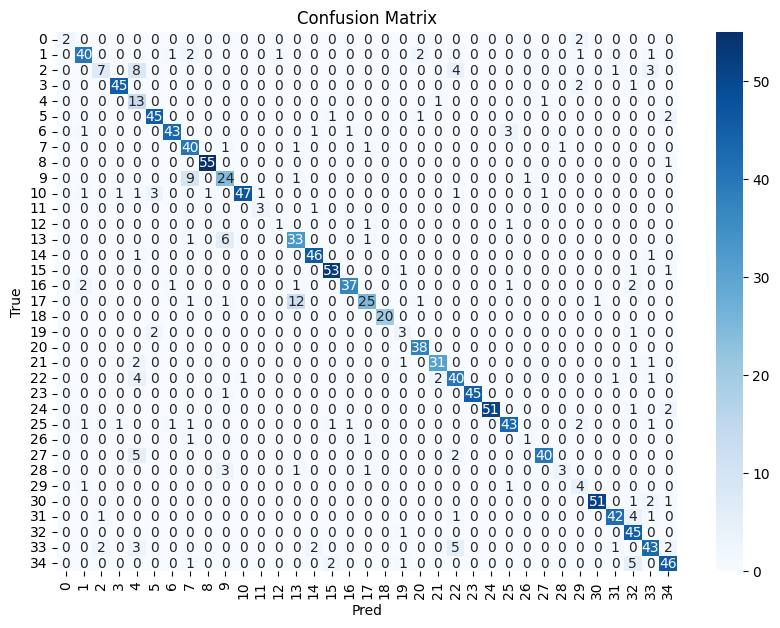

0.855


In [28]:
CM = confusion_matrix(t.numpy(), p.numpy())
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(round(test_accuracy, 3))

# Обучение

In [2]:
label_id = pd.DataFrame(data=pd.read_csv('label_to_id.csv', delimiter='\t'))
df = pd.DataFrame(data=pd.read_csv('train.csv', delimiter='\t'))
df = df.sample(frac=1, random_state=12312)

In [5]:
# image_size = 224
# x_train, x_test, y_train, y_test = load_data(df, image_size, aug=True, device=device)

 70%|██████▉   | 5993/8615 [01:09<00:27, 95.06it/s] c:\Users\Stanislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 367/367 [00:02<00:00, 173.83it/s]


In [6]:
# torch.save(x_train, 'x_train_aug_2')
# torch.save(x_test, 'x_test_aug_2')
# torch.save(y_train, 'y_train_aug_2')
# torch.save(y_test, 'y_test_aug_2')

In [6]:
x_train = torch.load('x_train_aug_2')
x_test = torch.load('x_test_aug_2')
y_train = torch.load('y_train_aug_2')
y_test = torch.load('y_test_aug_2')

In [7]:
x_train, x_test = x_train / 255, x_test / 255
y_train = y_train.type(torch.float32)
y_test = y_test.type(torch.float32)
train_loader = DataLoader(TensorDataset(x_train, y_train), pin_memory=True, batch_size=20)
test_loader = DataLoader(TensorDataset(x_test, y_test), pin_memory=True, batch_size=20)

In [10]:
model = timm.create_model("hf_hub:timm/beitv2_large_patch16_224.in1k_ft_in22k", pretrained=True)
model

Beit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [11]:
model.head = nn.Linear(1024, 35)
model.head

Linear(in_features=1024, out_features=35, bias=True)

In [12]:
model = model.to(device)

In [13]:
learning_rate = 3e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
weight_ce = 1 / (y_train.sum(dim=0) / y_train.sum(dim=0).sum()) / (1 / (y_train.sum(dim=0) / y_train.sum(dim=0).sum())).sum()
losser = torch.nn.CrossEntropyLoss(weight=weight_ce.to(device))
scaler = GradScaler()

In [20]:
# best_acc = 0
epochs = 3
model.train()
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    
    for images, labels in tqdm(train_loader):
        x, y = images.to(device), labels.to(device)
        with autocast():
            pred = model(x)
            loss = losser(pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_accuracy += get_num_correct(pred, y)

    
    for images, labels in tqdm(test_loader):
        x, y = images.to(device), labels.to(device)
        with torch.no_grad():
            with autocast():
                pred = model(x)
                loss = losser(pred, y)
        scaler.scale(loss)
        test_loss += loss.item()
        test_accuracy += get_num_correct(pred, y)

    train_accuracy = train_accuracy / len(train_loader.dataset)
    test_accuracy = test_accuracy / len(test_loader.dataset)
    print(f'Epoch: {epoch+1}', f'test acc: {test_accuracy}', f'train acc: {train_accuracy}', f'test loss: {round(test_loss, 3)}', f'train loss: {round(train_loss, 3)}')
    if test_accuracy > best_acc and test_accuracy > train_accuracy * 0.9:
        torch.save(model, f'beitv2_large_patch16_224.in1k_ft_in22k_{test_accuracy}_{train_accuracy}')
        best_acc = test_accuracy

100%|██████████| 65/65 [00:12<00:00,  5.32it/s]


Epoch: 1 test acc: 0.8546017014694509 train acc: 0.9294591641627971 test loss: 0.607 train loss: 2.144


 14%|█▎        | 99/733 [01:04<06:53,  1.53it/s]


KeyboardInterrupt: 